In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
import random

In [7]:
# Graphing code
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

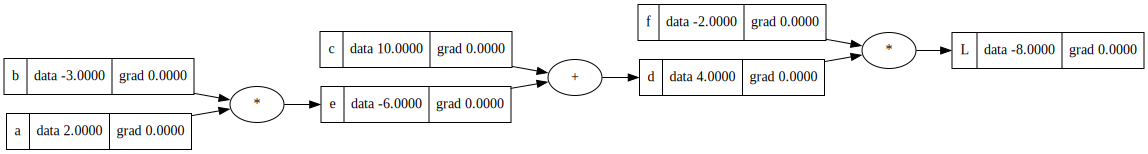

In [74]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None # backward pass function
    
    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            """Why do we accumulate gradients?

            When you have 2 of the same nodes (e.g. a + a = b) where self and other are the same node
            then you need to accumulate the gradients. Otherwise, otherwise each individual node will
            only have 1 gradient and will overwrite each other (resulting in half the value). See video
            1:23:44 at https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ.
            """
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), '^')
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        """ Backpropagate gradients through the graph.
        Intuitively the backward function worksl ike this. Each node when it is created in the forward pass is assigned a _backward function with pointers to the nodes that were involved with creating it. Upon running _backward on each node in this function, the functions update the gradients of the nodes that were involved in creating it. This is done recursively until the gradients of all the nodes in the graph are updated.

        For example, when you run it on the final -8 node, "self" and "other" are pointing to the -2 and 4 nodes respectively.
        """
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')


e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
draw_dot(L)


# # Compute gradients using the chain rule manually
# L.grad =1
# f.grad = 4
# d.grad = -2
# e.grad = -2
# c.grad = -2
# b.grad = -2 * 2
# a.grad = -2 * -3

In [22]:
e = 

node Value(-8.0)
node Value(-2.0)
node Value(4.0)
node Value(10.0)
node Value(-6.0)
node Value(2.0)
node Value(-3.0)


In [5]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')
    f.data += h

    L = d*f; L.label = 'L'
    L2 = L.data

    print(L2 - L1)

lol()


0.001399940000002431


node Value(0.6043677771171637)
node Value(0.1978161114414182)
node Value(5.055199966844676)
node Value(1)
node Value(3.0551999668446763)
node Value(4.055199966844676)
node Value(1.4000000000000004)
node Value(0.7000000000000002)
node Value(6.7)
node Value(-6.0)
node Value(-6.0)
node Value(-3.0)
node Value(2.0)
node Value(0.0)
node Value(1.0)
node Value(0.0)
node Value(2)
node Value(-1)


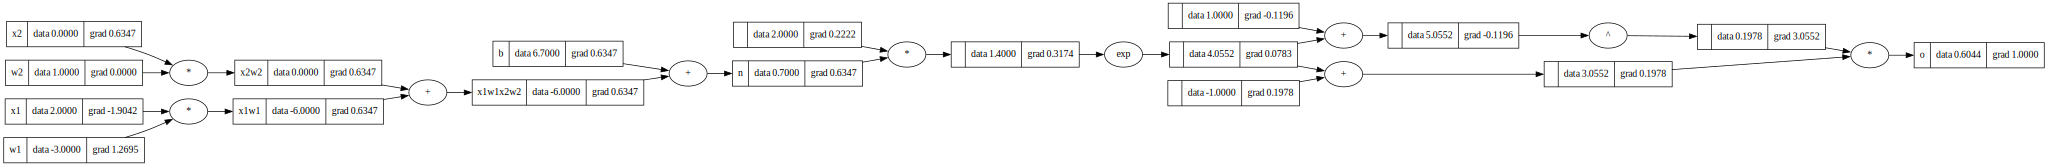

In [25]:
# building a neuron with manual backpropagation
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1) ; o.label = 'o'


# o = n.tanh(); o.label = 'o'

# Manually compute gradients. + nodes pass gradients on. * nodes multiply gradients
# o.grad = 1
# n.grad = 1 - o.data**2
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# Automatic compute gradients
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

# Compute it recursively
o.backward()

# Graph it
draw_dot(o)

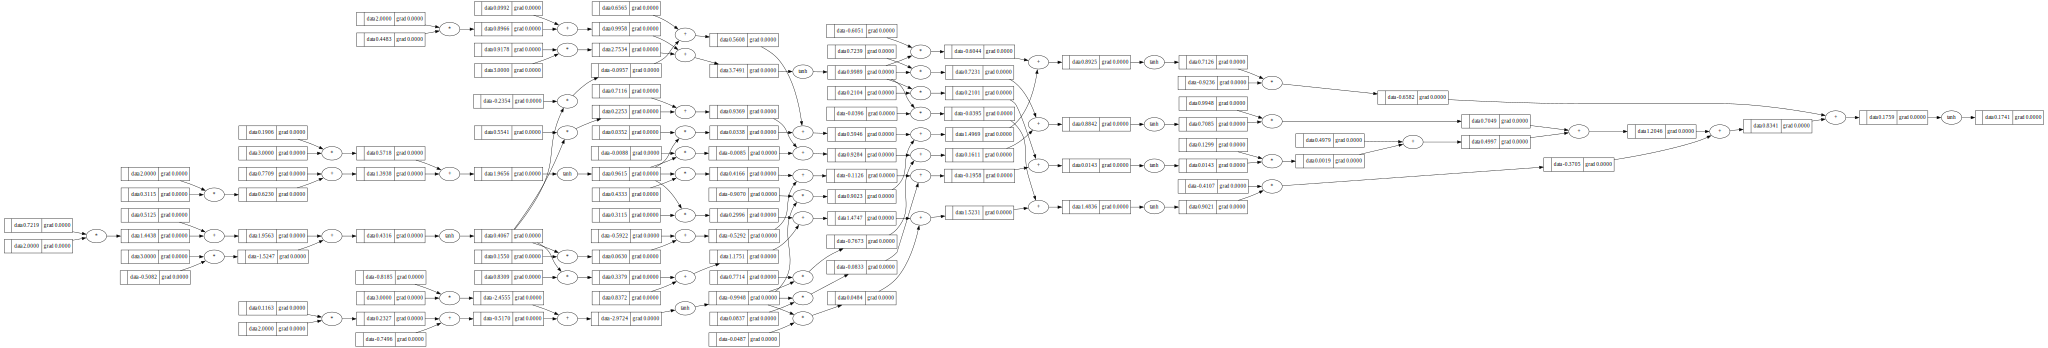

In [93]:
# Building a multilayer perceptron
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """x is the input"""
        z = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = z.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters]

class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts # [nin] for first layer to map to input size then nouts is all the subsequent layers.
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

l = Layer(2, 2)
l(x)

mlp = MLP(2, [4, 4, 1])
result = mlp(x)
draw_dot(result)

In [94]:
# Run our basic MLP on a basic dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(0.17414081228814068),
 Value(0.8476820806238435),
 Value(0.12249741076181789),
 Value(0.2531635498742984)]

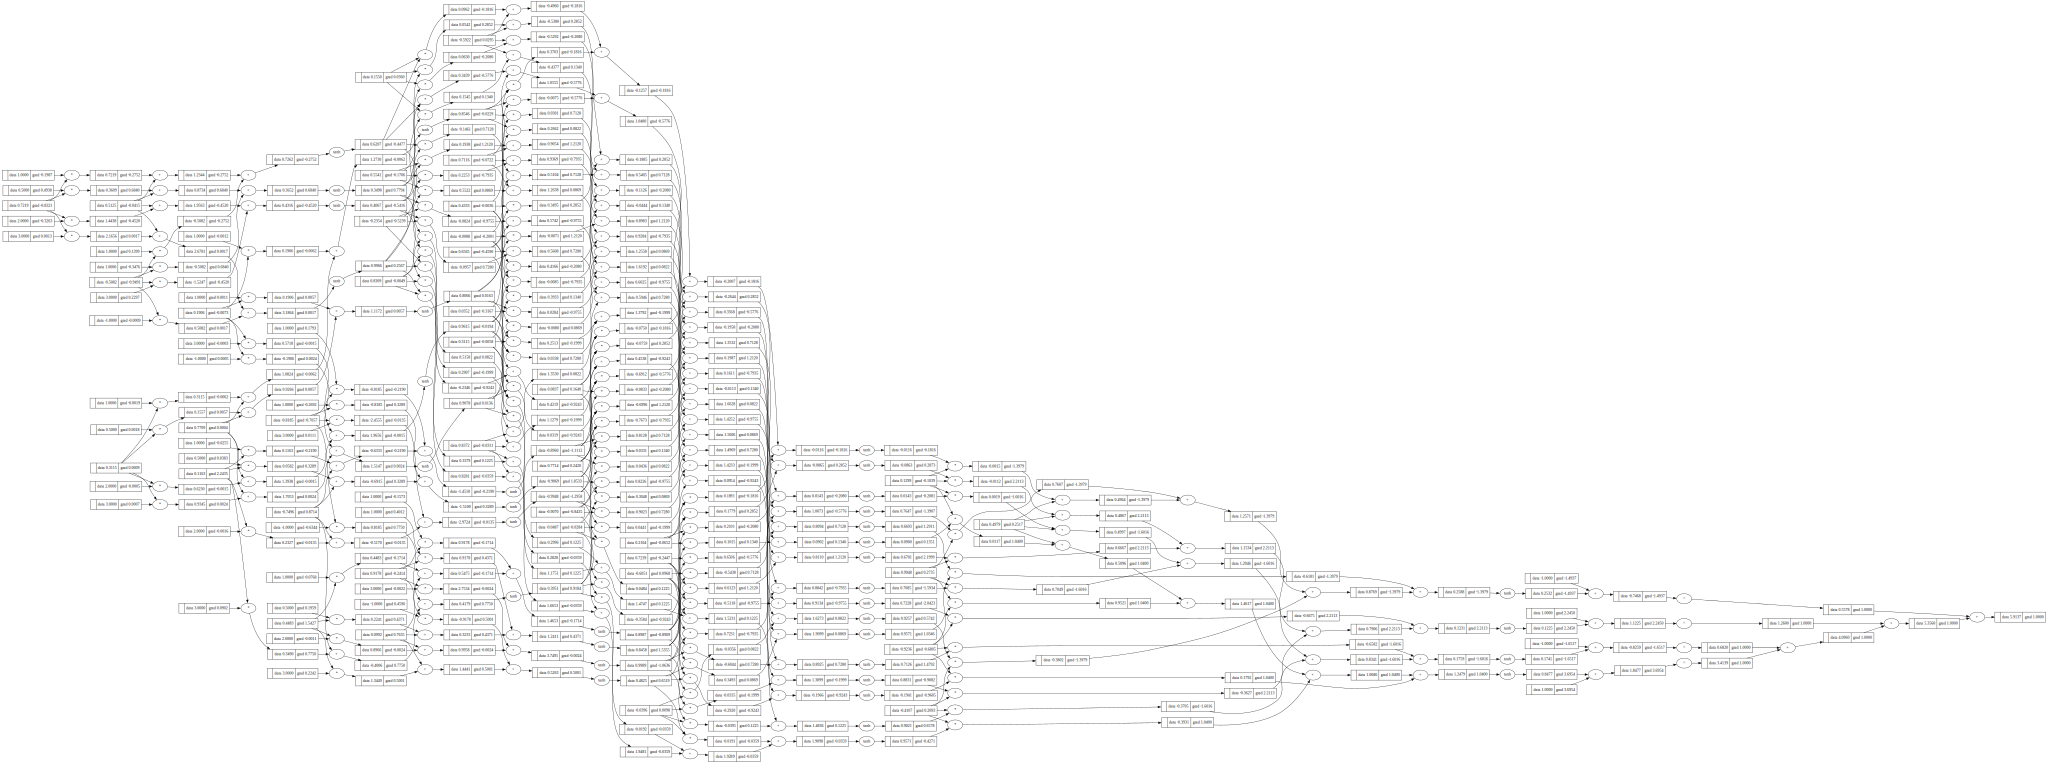

In [95]:
# MSE loss

loss = [(yp - ygt)**2 for ygt, yp in zip(ys, ypred)]
loss = loss[0] + loss[1] + loss[2] + loss[3]
loss.backward()

In [96]:
mlp.layers[0].neurons[0].w[0].grad

# 2:00:00 https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3


-0.8320721306189522